## Notebook to Replicate MOSTA Mouse Embryo results (Fig 3)
#### Landmark distance

---

**Author:** Benedetta Manzato  
**Date:** 30 October 2025

**Download:** https://db.cngb.org/stomics/mosta/download/

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
import anndata as ad
import scikit_posthocs as sp
import itertools

import warnings
warnings.filterwarnings("ignore")

ds = 'MOSTA_Mouse_Embryo_Stereoseq'
wd = f'/exports/humgen/bmanzato/valid_data/{ds}'
benchmark_dir = '/exports/humgen/bmanzato/benchmark'

#### Read landmarks csv and tile-centroid file 

In [6]:
landmarks = pd.read_csv(f"{wd}/landmarks/landmarks.csv", index_col=0, header=None)
landmarks.columns = ['TF', 'query_x', 'query_y', 'ref_x', 'ref_y']  
    
# Read ViT data
vit_coord_1 = pd.read_csv(f"{wd}/ViT/ViT_coord_E2S6_224.csv", index_col=0)
vit_coord_2 = pd.read_csv(f"{wd}/ViT/ViT_coord_E2S7_224.csv", index_col=0)

vit_coord_1.index = vit_coord_1.index.astype(str) + '_s1'
vit_coord_2.index = vit_coord_2.index.astype(str) + '_s2'

vit_coord_1_filt = vit_coord_1[~vit_coord_1.index.str.endswith("_outside_s1")]
vit_coord_2_filt = vit_coord_2[~vit_coord_2.index.str.endswith("_outside_s2")]

# Map the closest index to the landmarks -- img 2
tree = cKDTree(vit_coord_2_filt[['x', 'y']].values)
_, indices = tree.query(landmarks[['ref_x', 'ref_y']].values, k=1)
landmarks['closest_point_ref'] = vit_coord_2_filt.index[indices]

# Map the closest index to the landmarks -- img 1
tree = cKDTree(vit_coord_1_filt[['x', 'y']].values)
_, indices = tree.query(landmarks[['query_x', 'query_y']].values, k=1)
landmarks['closest_point_query'] = vit_coord_1_filt.index[indices]

#### Read aligned files for (1) COAST, (2) Rigid Alignment, (3) Unaligned, (4) CAST

In [8]:
# Read aligned coordinates for COAST
coordfinal_1 = pd.read_csv(f"{wd}/coord_final/coord_final_E165_E2S6.csv", index_col=0)
coordfinal_1.index = vit_coord_1.index
coordfinal_1_filt = coordfinal_1[~coordfinal_1.index.str.endswith("_outside_s1")]
# Map new coordinates
landmarks['COAST_aligned_stack_x'] = landmarks['closest_point_query'].map(coordfinal_1_filt['0'])
landmarks['COAST_aligned_stack_y'] = landmarks['closest_point_query'].map(coordfinal_1_filt['1'])


# Read aligned coordinates for RA
coordfinal_1_ra = pd.read_csv(f"{benchmark_dir}/Rigid_Alignment/{ds}/RA_e2s6_aligned.csv", index_col=0)
coordfinal_1_ra.columns = ['x', 'y']
coordfinal_1_ra.index = vit_coord_1_filt.index
# Map new coordinates
landmarks['RA_aligned_x'] = landmarks['closest_point_query'].map(coordfinal_1_ra['x'])
landmarks['RA_aligned_y'] = landmarks['closest_point_query'].map(coordfinal_1_ra['y'])

# Read aligned coordinates for Unaligned
coordfinal_1_no = vit_coord_1_filt
coordfinal_1_no.columns = ['x', 'y']
coordfinal_1_no.index = vit_coord_1_filt.index
# Map new coordinates
landmarks['NO_aligned_x'] = landmarks['closest_point_query'].map(coordfinal_1_no['x'])
landmarks['NO_aligned_y'] = landmarks['closest_point_query'].map(coordfinal_1_no['y'])


# Read aligned coordinates for CAST
coordfinal_1_cast = pd.read_csv(f"{benchmark_dir}/CAST/{ds}/output/coord_final_e2s6.csv", index_col=0)
coordfinal_1_cast.columns = ['x', 'y']
coordfinal_1_cast.index = vit_coord_1_filt.index
# Map new coordinates
landmarks['CAST_aligned_x'] = landmarks['closest_point_query'].map(coordfinal_1_cast['x'])
landmarks['CAST_aligned_y'] = landmarks['closest_point_query'].map(coordfinal_1_cast['y'])

#### Read aligned files for (5) MOSCOT

For MOSCOT we need to identify an offset for x and y for which the coordinates have been translated in the alignment step

In [9]:
moscot_output = ad.read_h5ad(f"{benchmark_dir}/MOSCOT/MOSTA_Mouse_Embryo_Stereoseq/output/adata_with_affinecoord.h5ad")

coordfinal_2_moscot = moscot_output[moscot_output.obs.index.str.startswith('s2')]
coordfinal_2_moscot.obs['offset_x'] = coordfinal_2_moscot.obs['affine-x'] - coordfinal_2_moscot.obs['x']
coordfinal_2_moscot.obs['offset_y'] = coordfinal_2_moscot.obs['affine-y'] - coordfinal_2_moscot.obs['y']
coordfinal_2_moscot.obs.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,annotation,Regulon - Alx1,Regulon - Alx3,Regulon - Alx4,Regulon - Arid3a,Regulon - Arx,...,xy_pixel,y_pxl,x_pxl,section,x,y,affine-x,affine-y,offset_x,offset_y
cell_name,,,,,,,,,,,,,,,,,,,,,
s2-111_242,567,6.342121,932,6.838405,Epidermis,0.045905,0.010457,0.026602,0.084407,0.001834,...,5475_12108,27697,8549,e2s7,8549,27697,960.249026,13943.677875,-7588.750974,-13753.322125
s2-112_242,741,6.609349,1338,7.199678,Cavity,0.005361,0.061916,0.032051,0.005186,0.000687,...,5557_12113,27615,8544,e2s7,8544,27615,955.249026,13861.677875,-7588.750974,-13753.322125
s2-112_249,1060,6.966967,2018,7.610358,Cavity,0.063712,0.036915,0.085112,0.187947,0.000394,...,5556_12472,27616,8185,e2s7,8185,27616,596.249026,13862.677875,-7588.750974,-13753.322125
s2-113_232,613,6.419995,1122,7.023759,Epidermis,0.050953,0.066719,0.065877,0.089222,0.003175,...,5577_11620,27595,9037,e2s7,9037,27595,1448.249026,13841.677875,-7588.750974,-13753.322125
s2-113_234,602,6.401917,1077,6.982863,Epidermis,0.071142,0.018984,0.026192,0.051237,0.039106,...,5622_11724,27550,8933,e2s7,8933,27550,1344.249026,13796.677875,-7588.750974,-13753.322125


In [10]:
# Read aligned coordinates for MOSCOT
coordfinal_1_moscot = moscot_output[moscot_output.obs.index.str.startswith('s1')]
coordfinal_1_moscot = coordfinal_1_moscot.obs[['affine-x', 'affine-y']]
coordfinal_1_moscot.columns = ['x','y']

coordfinal_1_moscot['x'] = coordfinal_1_moscot['x']-coordfinal_2_moscot.obs['offset_x']
coordfinal_1_moscot['y'] = coordfinal_1_moscot['y']-coordfinal_2_moscot.obs['offset_y']

coordfinal_1_moscot.index = vit_coord_1_filt.index
# Map new coordinates
landmarks['MOSCOT_aligned_x'] = landmarks['closest_point_query'].map(coordfinal_1_moscot['x'])
landmarks['MOSCOT_aligned_y'] = landmarks['closest_point_query'].map(coordfinal_1_moscot['y'])

#### Calculate Euclidean distances

In [11]:
landmarks['COAST_distance'] = np.sqrt((landmarks['ref_x'] - landmarks['COAST_aligned_stack_x'])**2 +
                                            (landmarks['ref_y'] - landmarks['COAST_aligned_stack_y'])**2)
landmarks['Unalig_distance'] = np.sqrt((landmarks['ref_x'] - landmarks['NO_aligned_x'])**2 +
                                       (landmarks['ref_y'] - landmarks['NO_aligned_y'])**2)
landmarks['RA_distance'] = np.sqrt((landmarks['ref_x'] - landmarks['RA_aligned_x'])**2 +
                                       (landmarks['ref_y'] - landmarks['RA_aligned_y'])**2)
landmarks['CAST_distance'] = np.sqrt((landmarks['ref_x'] - landmarks['CAST_aligned_x'])**2 +
                                       (landmarks['ref_y'] - landmarks['CAST_aligned_y'])**2)
landmarks['MOSCOT_distance'] = np.sqrt((landmarks['ref_x'] - landmarks['MOSCOT_aligned_x'])**2 +
                                       (landmarks['ref_y'] - landmarks['MOSCOT_aligned_y'])**2)
# Drop NaN values
landmarks_clean = landmarks[['COAST_distance', 'Unalig_distance', 'RA_distance','CAST_distance','MOSCOT_distance']].dropna()

landmarks_clean.head()

,COAST_distance,Unalig_distance,RA_distance,CAST_distance,MOSCOT_distance
0,,,,,
Pt-0,325.052055,1012.647094,817.891474,704.252179,822.173477
Pt-1,210.038588,408.559220,215.795305,435.727433,695.347193
Pt-2,286.207959,1052.075822,852.192563,113.459093,1026.649160
Pt-3,380.762368,1373.892362,1218.202507,639.398133,934.067252
Pt-4,277.891939,968.632035,771.930411,999.859831,1497.444241


#### Boxplot landmark distances per method

Kruskal-Wallis Test: p=0.00000
Overall p-value: 0.00000


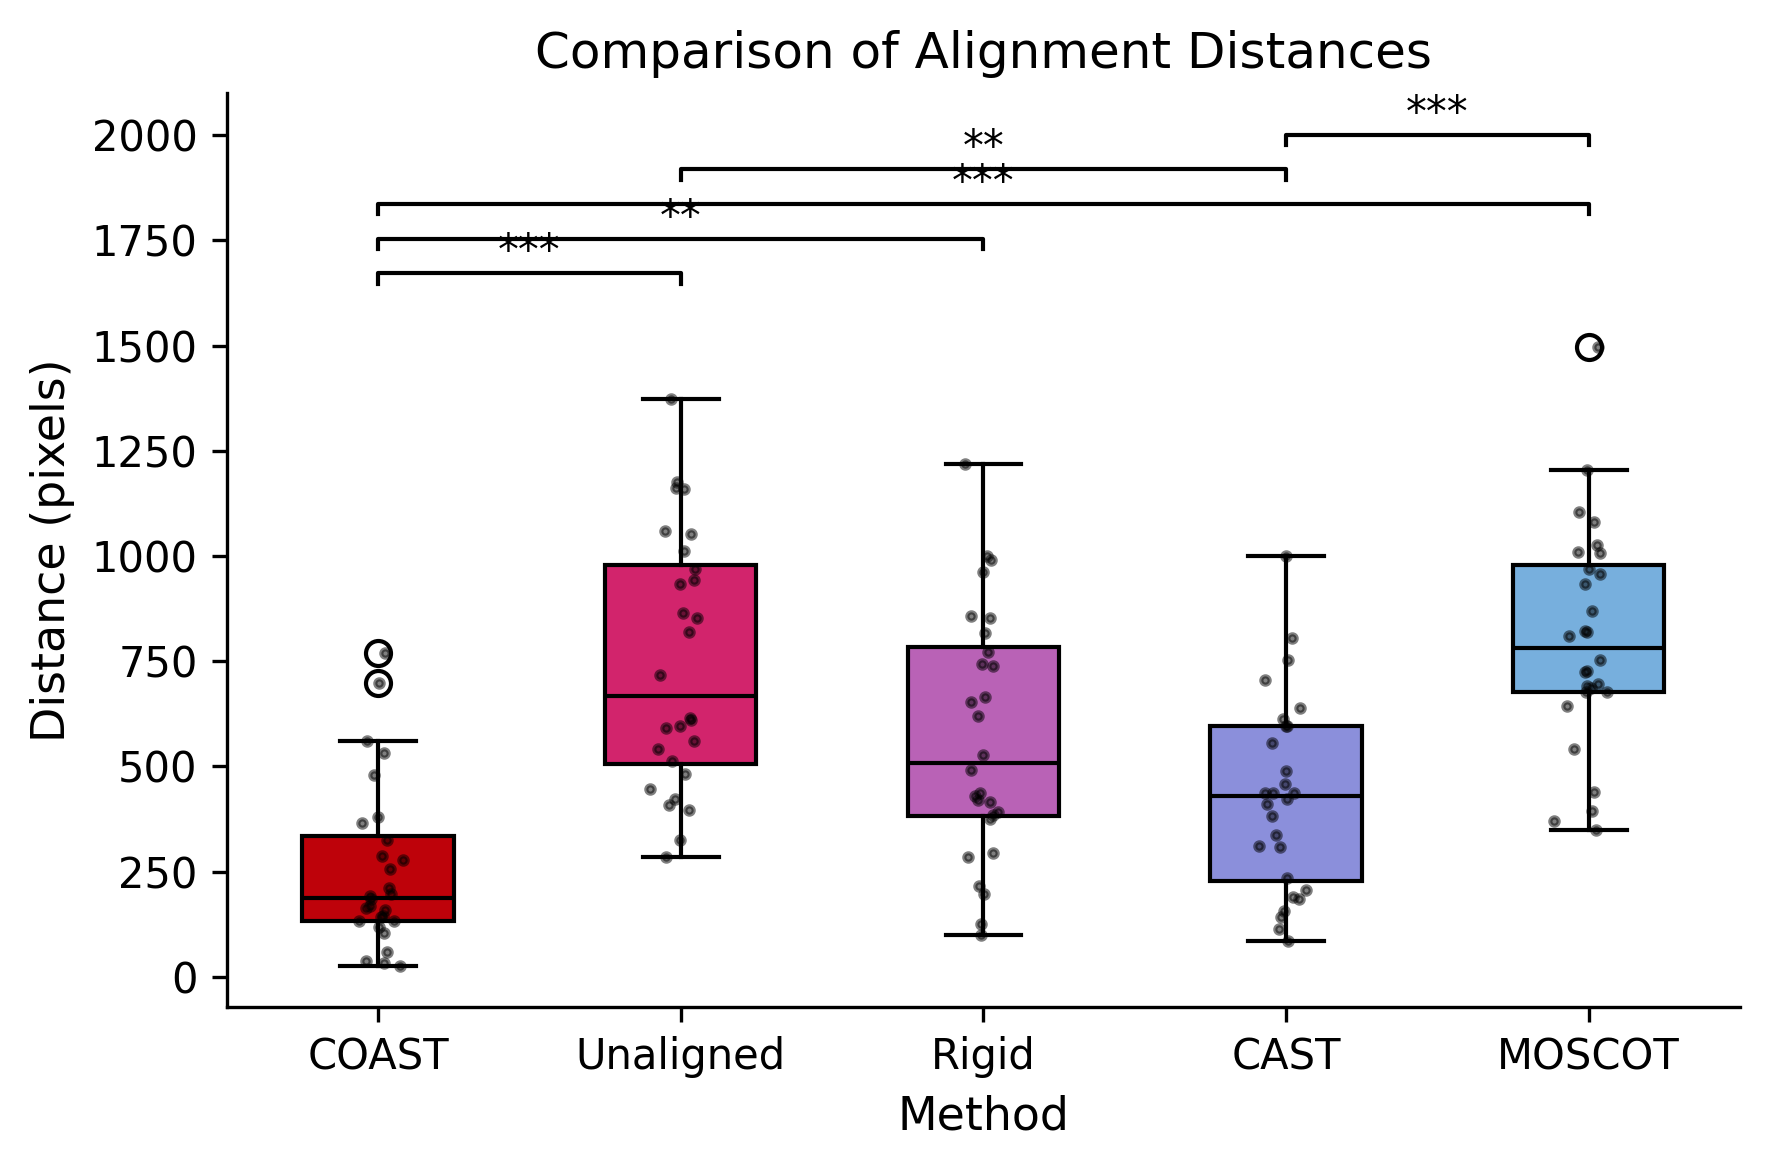

In [12]:
# distances
methods = ["COAST_distance", "Unalig_distance", "RA_distance", "CAST_distance", "MOSCOT_distance"]
labels = ["COAST", "Unaligned", "Rigid", "CAST", "MOSCOT"]
colors = ["#be020a", "#d2246c", "#b962b6", "#8b8fdb", "#77afdd"]
data = [landmarks_clean[m] for m in methods]

shapiro_results = [stats.shapiro(landmarks_clean[m]) for m in methods]
normal = all(r.pvalue > 0.05 for r in shapiro_results)

# choose test
if normal:
    stat, p_value = stats.f_oneway(*data)
    test_used = "One-way ANOVA"
else:
    stat, p_value = stats.kruskal(*data)
    test_used = "Kruskal-Wallis Test"

print(f"{test_used}: p={p_value:.5f}")  # original
print(f"Overall p-value: {p_value:.5f}")  # <-- added line

# post-hoc test: Dunn's (for Kruskal-Wallis)
posthoc = sp.posthoc_dunn([landmarks_clean[m] for m in methods], p_adjust='bonferroni')
posthoc.index = labels
posthoc.columns = labels

# boxplot
plt.figure(figsize=(6,4), dpi=300)
box = plt.boxplot(data, patch_artist=True, labels=labels, widths=0.5,
                  medianprops=dict(color="black"),
                  boxprops=dict(linewidth=1.0), 
                  whiskerprops=dict(linewidth=1.0),
                  capprops=dict(linewidth=1.0))

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for i, (y, color) in enumerate(zip(data, colors)):
    x = np.random.normal(i+1, 0.04, size=len(y))
    plt.plot(x, y, 'o', color='black', alpha=0.5, markersize=2)

# significance stars
def add_sig_line(x1, x2, y, h, p_val, fs=10):
    """Add significance line between box x1 and x2 at height y"""
    sig = ""
    if p_val < 0.001:
        sig = '***'
    elif p_val < 0.01:
        sig = '**'
    elif p_val < 0.05:
        sig = '*'
    if sig:
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, color='black')
        plt.text((x1 + x2) * 0.5, y + h + 0.002, sig, ha='center', va='bottom', color='black', fontsize=fs)

y_max = max([max(d) for d in data]) * 1.1
step = (y_max / 20)
i = 0
for (a, b) in itertools.combinations(range(len(labels)), 2):
    p_val = posthoc.iloc[a, b]
    if p_val < 0.05:
        add_sig_line(a+1, b+1, y_max + i*step, step*0.3, p_val)
        i += 1

plt.title("Comparison of Alignment Distances", fontsize=12)
plt.ylabel("Distance (pixels)", fontsize=11)
plt.xlabel("Method", fontsize=11)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


In [13]:
# fix index 
landmarks_clean.index = [f'Pt-{i}' for i in range(len(landmarks_clean))]

#### Barplot of individual landmark distances per method

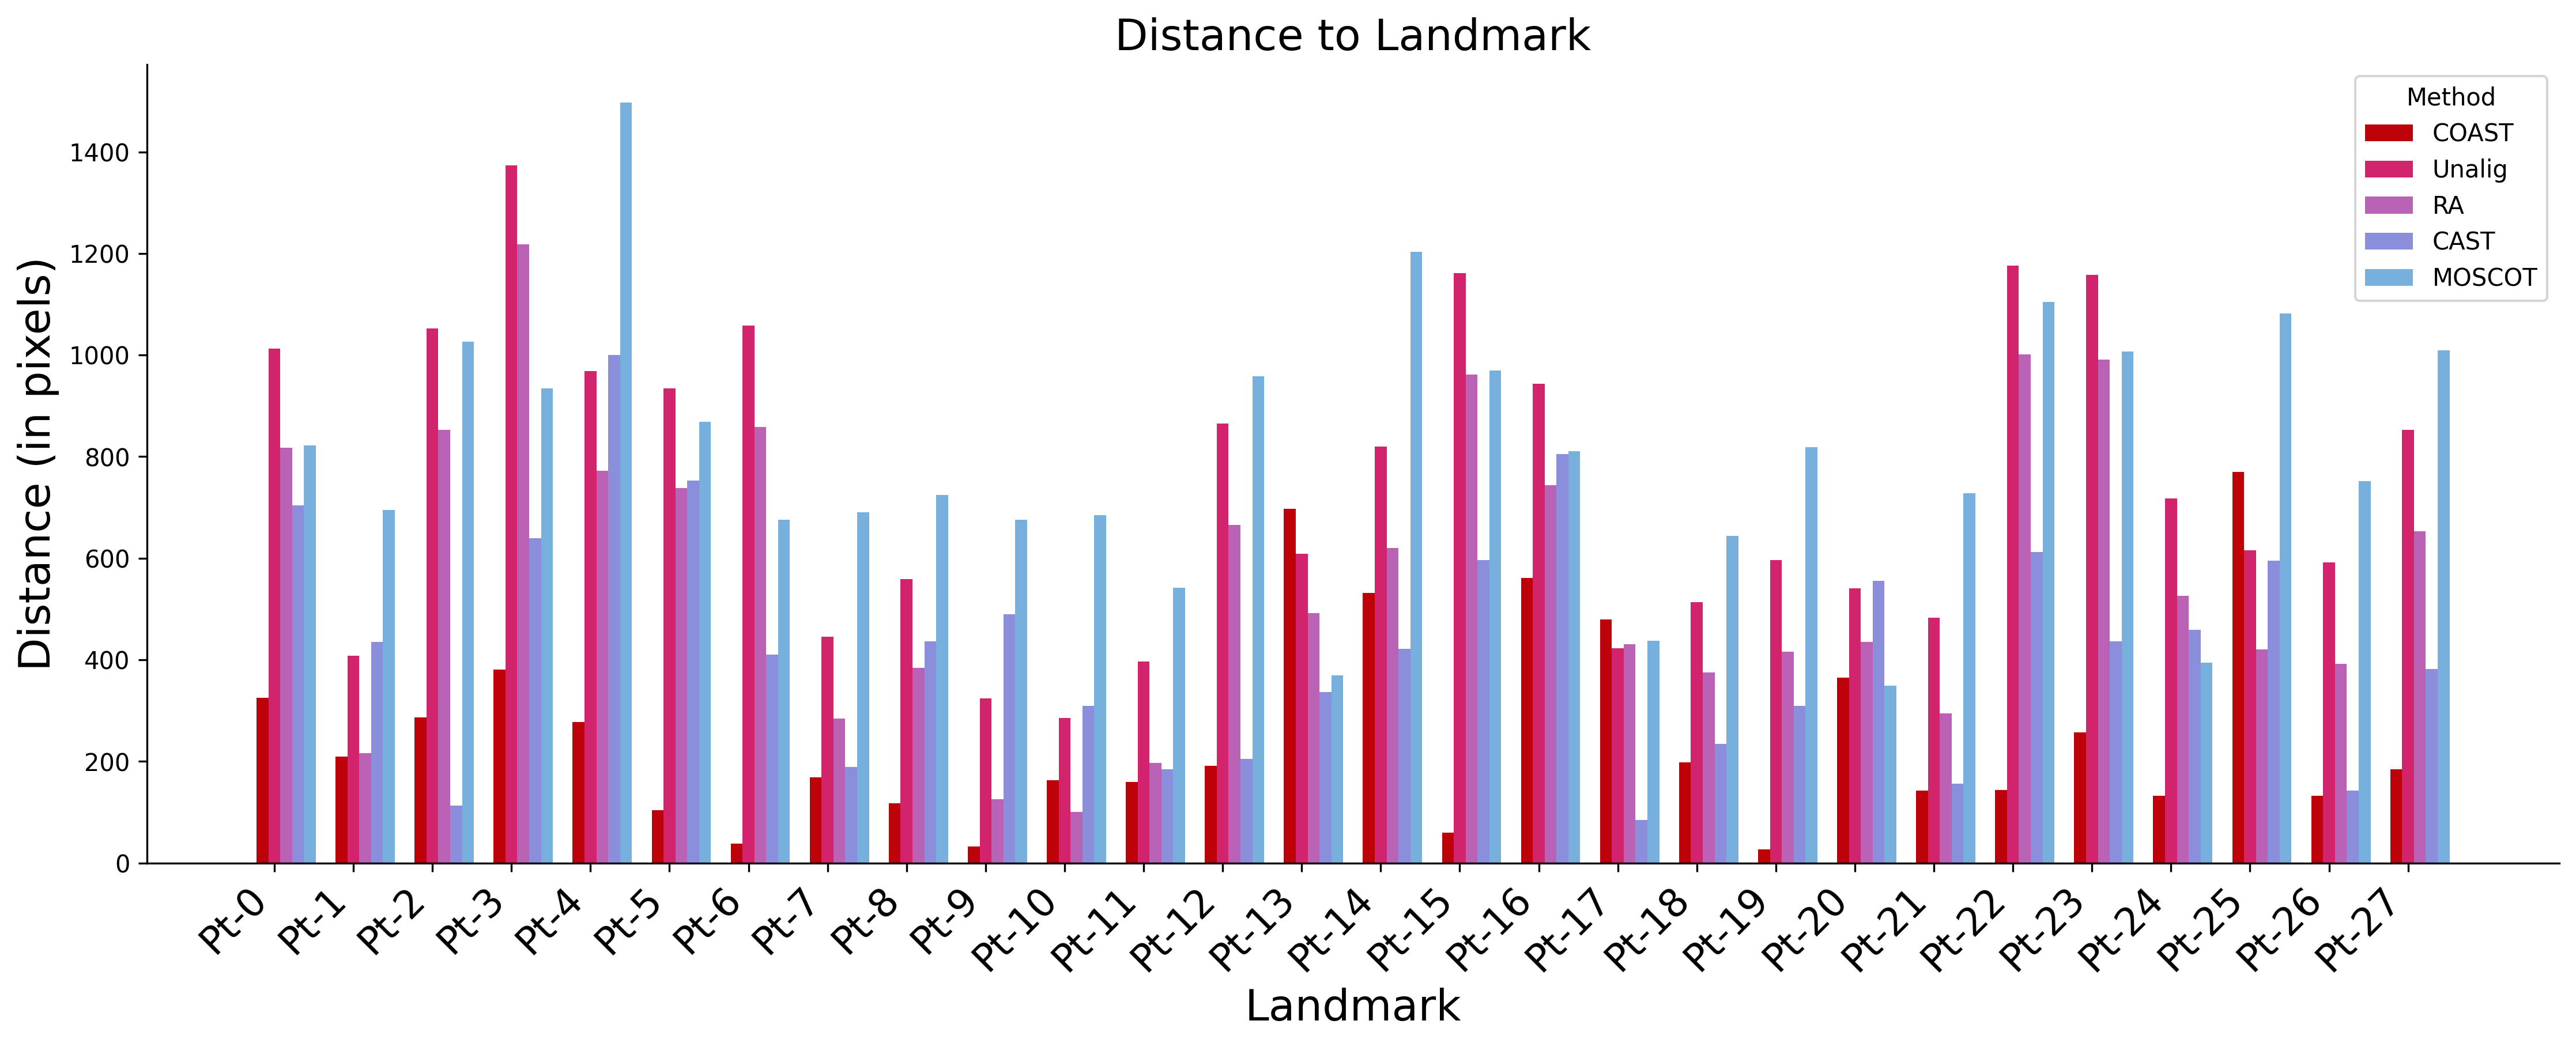

In [14]:
landmarks_clean['Point'] = landmarks_clean.index
df_melted = landmarks_clean.melt(id_vars='Point', var_name='Distance Type', value_name='Distance')

color_mapping = {
    "COAST_distance": "#be020a",
    "Unalig_distance": "#d2246c",  
    "RA_distance": "#b962b6",
    "CAST_distance": "#8b8fdb",
    "MOSCOT_distance": "#77afdd"
}

points = df_melted["Point"].unique()
distance_types = df_melted["Distance Type"].unique()

bar_width = 0.15
bar_positions = np.arange(len(points))

# fig
plt.figure(figsize=(18, 6), dpi=300)

for i, dist_type in enumerate(distance_types):
    subset = df_melted[df_melted["Distance Type"] == dist_type]
    plt.bar(bar_positions + i * bar_width, 
            subset["Distance"], 
            width=bar_width, 
            label=dist_type.split('_')[0],  # Clean label
            color=color_mapping[dist_type])

plt.xticks(bar_positions + bar_width, points, rotation=45, ha="right", fontsize=16)
plt.xlabel("Landmark", fontsize=18)
plt.ylabel("Distance (in pixels)", fontsize=18)
plt.title("Distance to Landmark", fontsize=18)
plt.legend(title="Method")

ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.show()


#### Calculate and print median, max, and min for each method

In [15]:
columns = [
    "COAST_distance",
    "Unalig_distance",
    "RA_distance",
    "CAST_distance",
    "MOSCOT_distance",
]

for col in columns:
    median_val = landmarks_clean[col].median()
    max_val = landmarks_clean[col].max()
    min_val = landmarks_clean[col].min()
    
    print(f"{col} - Median: {median_val:.2f}, Max: {max_val:.2f}, Min: {min_val:.2f}")


COAST_distance - Median: 187.94, Max: 769.38, Min: 26.66
Unalig_distance - Median: 666.59, Max: 1373.89, Min: 284.95
RA_distance - Median: 509.11, Max: 1218.20, Min: 100.44
CAST_distance - Median: 428.80, Max: 999.86, Min: 85.11
MOSCOT_distance - Median: 781.30, Max: 1497.44, Min: 348.83
